# 04: Weighting, Rolling, and EOFs - More on Time Series in xarray

To construct and analyze time series, we often need to process the data to isolate regions or time scales of interest. This tutorial provides examples for two of the more common processing tasks, area-weighted averaging and rolling means.

In [1]:
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import colormaps

The next step is to load the dataset. This time we use a time series of global sea surface temperatures from the [Centennial in situ Observation-Based Estimates version 2 (COBE2)]() analysis prepared by the [Japan Meteorological Agency](https://www.jma.go.jp/jma/indexe.html). The data are provided on a 1° regular latitude-longitude grid as monthly means covering the period from January 1850 until the end of 2024. To reduce the size of the data file, I have selected only the Atlantic sector between 40°S and 40°N.

In [2]:
sst = xr.open_dataset('sst_cobe2.atlantic.1x1.1850-2024.1m.nc')['sst']

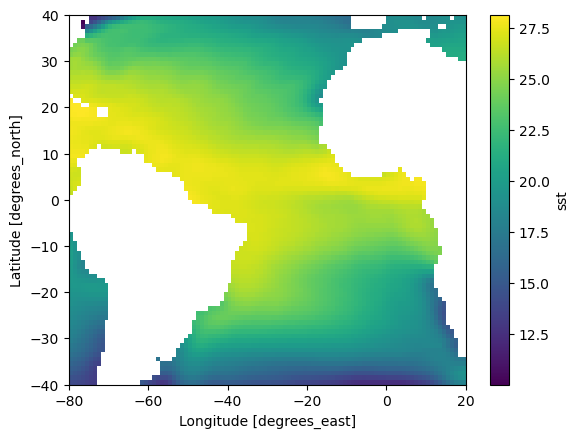

In [3]:
sst.mean('time').plot()

To construct time series based on area-mean values, we need to take into account differences in the areas of grid cells. For an xarray [DataArray or Dataset](https://tutorial.xarray.dev/fundamentals/01_datastructures.html) on a regular latitude-longitude grid, this can be accounted for by weighting the data object by the cosine of latitude. [Trigonometric functions](https://numpy.org/doc/stable/reference/routines.math.html) in numpy require input in radians, so we use [numpy.deg2rad()](https://numpy.org/doc/stable/reference/generated/numpy.deg2rad.html#numpy.deg2rad) to convert degrees latitude to radians first.
- [Weighted reductions in xarray](https://tutorial.xarray.dev/fundamentals/03.4_weighted.html)

Here we select a region in the [tropical North Atlantic](https://psl.noaa.gov/data/timeseries/month/DS/TNA/) commonly used as a climate index: 55°W to 15°W and 5°N to 25°N.

In [4]:
# weighted by cosine of latitude
weights = np.cos(np.deg2rad(sst.sel(lat=slice(25,5)).lat))
# in this dataset, latitude is ordered north to south
sst_tna = sst.sel(lat=slice(25,5), lon=slice(-55,-15)).weighted(weights).mean(['lon', 'lat'])

Note that slices for selecting from xarray data objects need to match the order of the dimension. In the COBE2 dataset, latitude is ordered north to south. You can avoid this by using [isel to select by index](https://tutorial.xarray.dev/fundamentals/02.1_indexing_Basic.html), but in this case you need to know the mapping between index and variable.
- [Advanced indexing](https://tutorial.xarray.dev/intermediate/indexing/advanced-indexing.html)
- [Boolean indexing](https://tutorial.xarray.dev/intermediate/indexing/boolean-masking-indexing.html)

Next, we use [groupby](https://tutorial.xarray.dev/fundamentals/03.2_groupby_with_xarray.html) to calculate the anomaly relative to the pre-industrial climatology, approximated as the 1850-1899 mean annual cycle. 

In [5]:
sst_tna = sst_tna.groupby('time.month') - sst_tna.sel(time=slice('1850','1899')).groupby('time.month').mean('time')

We can filter time series to reduce the noise at shorter timescales or isolate processes that evolve on particular time scales. Climate change evolves on relatively long time scales, so a low pass filter is often helpful for visualizing these changes. The simplest of these is probably already familiar to you: the [rolling average](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.rolling.html). 

In [6]:
# Apply a five-year (60-month) rolling average 
roll_sst = sst_tna.rolling(time=60, center=True).mean().dropna('time')
year = sst_tna['time'].dt.year.values
dcde = 1850 + 10*((year - year[0]) / 10).astype(int)
dec_sst = sst_tna.assign_coords({'decade': ('time', dcde)})

You can also define or adopt special window functions for applying rolling computations.
- [Windowed computations](https://tutorial.xarray.dev/fundamentals/03.3_windowed.html)

Below we plot the area-weighted area-mean sea surface temperature anomalies in the tropical North Atlantic as (1) annual means sorted by decade, (2) the rolling 12-month mean (thin grey line), and (3) the rolling five-year mean (thick black line). When plotting filtered result, we need to pay attention to alignment of the time series. [Rolling averages](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html) in xarray default to setting the edges of the dataset to [nan](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html) (['not-a-number'](https://numpy.org/doc/stable//reference/constants.html)). Two ways to deal with these edge effects are included below, one for each of the rolling time series. 

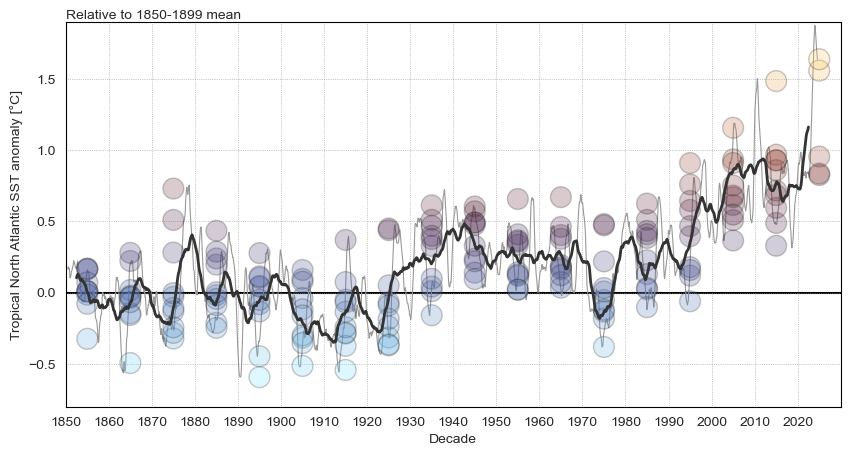

In [7]:
sns.set_style('white', {"axes.edgecolor": "k"})

# set the index for rolling 5-year mean to remove 2.5 years from the beginning and end (10 years = 1 increment)
dndx = np.linspace(-0.25,16.75,2041) 
# for 12-month rolling mean we achieve the same effect by not dropping the nan values
sst_12m = sst_tna.rolling(time=12, center=True).mean()
yndx = np.linspace(-0.5,17,2100) 

# take annual averages of the monthly mean anomalies
dyr_sst = dec_sst.groupby('time.year').mean('time').assign_coords({'decade': ('year', dcde[::12])}) 
# [::12] means every 12th value, from beginning to end of the array

fig, axs = plt.subplots(figsize=(10,5))
# Plotting
axs.axhline(0, color='k')
clrs = colormaps.managua_r
sns.stripplot(ax=axs, x=dyr_sst['decade'].values+5, y=dyr_sst.values, hue=dyr_sst.values, palette=clrs, legend=False, 
              jitter=False, s=15, marker='o', linewidth=1, alpha=0.25) # alpha controls transparency
axs.plot(dndx, roll_sst.values, color='#333', lw=2, zorder=10)
# this index removes 0.5 year from the beginning and end
axs.plot(yndx, sst_12m, color='#999', lw=0.8, zorder=2)
axs.set_ylim((-0.8, 1.9))
axs.set_xlim((-0.5,17.5))
axs.set_xticks(np.arange(-0.5,17))
axs.set_xticklabels(np.arange(1850,2021,10).astype('str'))
axs.set_ylabel('Tropical North Atlantic SST anomaly [°C]')
axs.set_xlabel('Decade')
axs.text(0, 1, 'Relative to 1850-1899 mean', ha='left', va='bottom', transform=axs.transAxes)
for yy in np.arange(-0.5,17):
    axs.axvline(yy, color='#999', ls=':', lw=0.5)
for tt in axs.yaxis.get_majorticklocs():
    axs.axhline(tt, color='#999', ls=':', lw=0.5)
plt.show()

One of the issues you may encounter in plotting time series is inconsistencies in how dates are dealt with in different modules. In this example, we have avoided the problem by using [seaborn.stripplot()](https://seaborn.pydata.org/generated/seaborn.stripplot.html) first. This sets the categories along the *x*-axis at unit intervals, each corresponding to one decade. Other approaches:
- [How matplotlib handles dates](https://matplotlib.org/stable/users/explain/axes/axes_units.html)
- [Axes and cftime: nc-time-axis](https://nc-time-axis.readthedocs.io/en/latest/)

For climate indices like the TNA, we often want to remove the long-term trend. Looking at the time series above (and in the previous tutorial for Dakar), a linear trend line is likely not the best option. The most straightforward option is to use a higher-order polynomial fit, such as quadratic (2nd-order) or quartic (4th-order). Again, xarray makes this easy.
- [DataArray polyfit](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.polyfit.html)
- [Comptation: fitting polynomials](https://docs.xarray.dev/en/stable/user-guide/computation.html#fitting-polynomials) 

In [8]:
linr = sst_tna.polyfit(dim='time', deg=1, full=True)
qudr = sst_tna.polyfit(dim='time', deg=2, full=True)
qurt = sst_tna.polyfit(dim='time', deg=4, full=True)

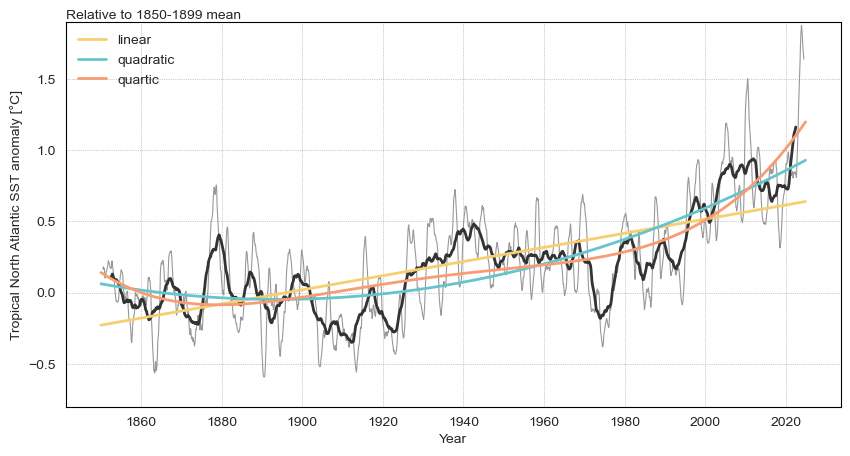

In [9]:
fig, axs = plt.subplots(figsize=(10,5))

roll_sst.plot(ax=axs, color='#333', lw=2, zorder=10, label='')
sst_12m.plot(ax=axs, color='#999', lw=0.8, zorder=2, label='')

# Polynomial fits
clrs = colormaps.pastel.colors
xr.polyval(coord=sst_tna.time, coeffs=linr.polyfit_coefficients).plot(ax=axs, color=clrs[1], 
                                                                      lw=2, zorder=10, label='linear')
xr.polyval(coord=sst_tna.time, coeffs=qudr.polyfit_coefficients).plot(ax=axs, color=clrs[0], 
                                                                      lw=2, zorder=10, label='quadratic')
xr.polyval(coord=sst_tna.time, coeffs=qurt.polyfit_coefficients).plot(ax=axs, color=clrs[2], 
                                                                      lw=2, zorder=10, label='quartic')

axs.legend(loc='upper left', frameon=False)
axs.set_ylim((-0.8, 1.9))
axs.set_ylabel('Tropical North Atlantic SST anomaly [°C]')
axs.set_xlabel('Year')
axs.text(0, 1, 'Relative to 1850-1899 mean', ha='left', va='bottom', transform=axs.transAxes)
for yy in axs.xaxis.get_majorticklocs()[1:-1]:
    axs.axvline(yy, color='#999', ls=':', lw=0.5)
for tt in axs.yaxis.get_majorticklocs():
    axs.axhline(tt, color='#999', ls=':', lw=0.5)
plt.show()

Whereas the linear fit shows too much warming in the early years and too little in later years, the quadratic and quartic fits match the long-term evolution of the TNA time series fairly well. In this case I would likely use the quadratic fit for detrending because it is less sensitive to the endpoints. The lack of trends before 1900 supports our use of the 1850-1899 period as the baseline climatology.

A more sophisticated option would be to use extended empirical orthogonal function analysis (also known as multivariate or multichannel singular spectrum analysis). The [xEOFs](https://xeofs.readthedocs.io/en/latest/index.html) package is a robust tool for computing EEOFs and other EOF-related analyses using xarray objects. 
- [Removing nonlinear trends with EEOF analysis](https://xeofs.readthedocs.io/en/latest/content/user_guide/auto_examples/1single/plot_eeof_trend.html)

In [10]:
import xeofs as xe

In [11]:
sst_xy = sst #.sel(lat=slice(25,5), lon=slice(-55,-15))
sst_xy = sst_xy.groupby('time.month') - sst_xy.sel(time=slice('1850','1899')).groupby('time.month').mean('time')

Paraphrasing from the example linked above, we perform an EEOF analysis on the deseasonalized monthly mean data with a relatively large embedding dimension (embedding = 120 months = 10 years) to highlight long-term trends. Reducing the dimensionality of the input data by selecting a suitably large number of principal components (n_pca_modes=50) speeds up the computation considerably (from more than 4 minutes to less than 4 seconds on my machine, for nearly identical results).

In [12]:
eeof = xe.single.ExtendedEOF(n_modes=5, tau=1, embedding=120, n_pca_modes=50)
eeof.fit(sst_xy, dim="time")
components_ext = eeof.components()
scores_ext = eeof.scores()

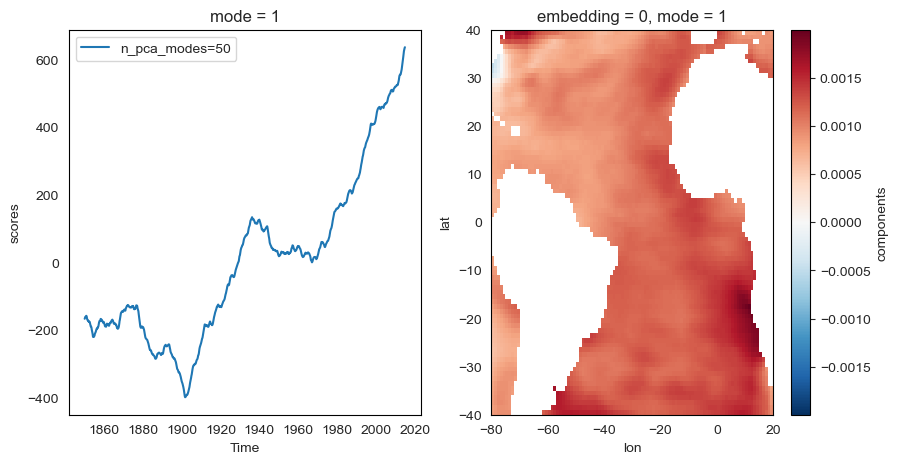

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
scores_ext.sel(mode=1).plot(ax=ax[0], label='n_pca_modes=50')
components_ext.sel(mode=1, embedding=0).plot(ax=ax[1])
ax[0].legend(loc='best')

This approach is more complicated than the polynomial fit, but also provides more information. In addition to the spatial structure of the trend, we can identify the influences of the relatively active volcanic period from the late 19th century into the early 20th century and the mid-20th century peak in aerosol emissions from North America and Europe in the time series. Note, however, that this approach may confuse multi-decadal variability and trends (perhaps especially for Atlantic SST).

Detrending the original data is then done by applying the reverse transform to only the leading mode:

In [14]:
sst_trends = eeof.inverse_transform(scores_ext.sel(mode=1))
sst_detrended = sst_xy - sst_trends

We can then apply a more standard EOF analysis to identify leading modes of variability in the Atlantic SST, with the caveat that these modes are statistically derived and are not always physically meaningful. You can think of this distinction as similar to ordinary least squares linear regression on a two-dimensional scatterplot: the linear fit describes the relationship according to a specific optimization (a squared-error loss function), which may or may not have a clear physical explanation.

In [15]:
eof_model_detrended = xe.single.EOF(n_modes=5)
eof_model_detrended.fit(sst_detrended, dim="time")
scores_detrended = eof_model_detrended.scores()
components_detrended = eof_model_detrended.components()

In this case, the first mode evokes [Atlantic Niño](https://www.aoml.noaa.gov/the-atlantic-nino-el-ninos-little-brother/), although it is a bit broader than this pattern is normally characterized. I have applied a three-month rolling mean to the principal component time series.

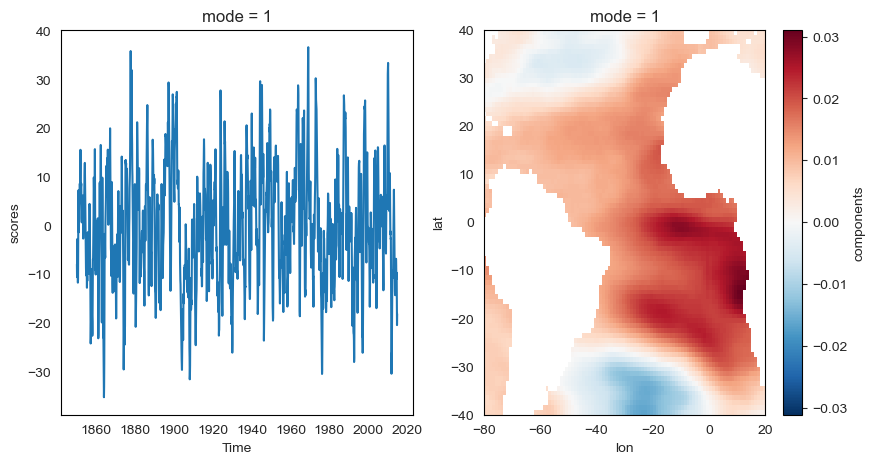

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
scores_detrended.sel(mode=1).rolling(time=3, center=True).mean().dropna('time').plot(ax=ax[0])
components_detrended.sel(mode=1).plot(ax=ax[1])

The second mode corresponds to the [tropical North Atlantic pattern](https://psl.noaa.gov/data/timeseries/month/DS/TNA/) described by the index we calculated above, along with its [mirror image in the Southern Hemisphere](https://www.wmolc.org/contents/index/Climate+Indices):

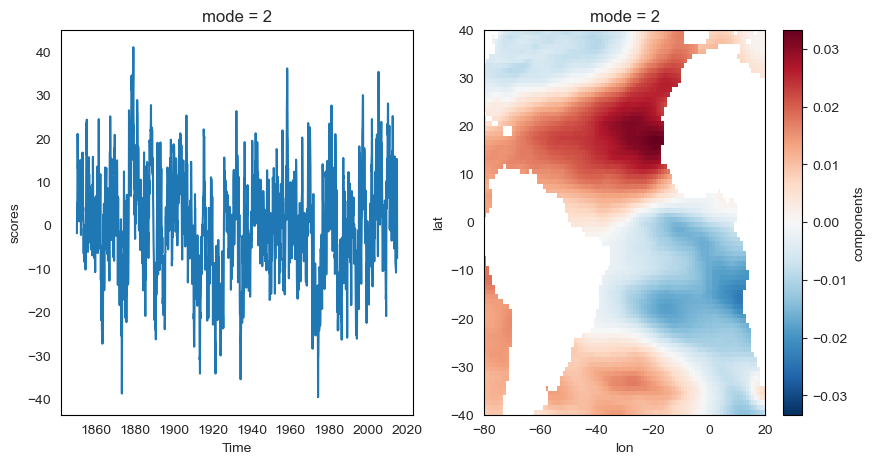

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
scores_detrended.sel(mode=2).plot(ax=ax[0])
components_detrended.sel(mode=2).plot(ax=ax[1])

To test this, we can evaluate the [Pearson correlation coefficient](https://docs.xarray.dev/en/stable/generated/xarray.corr.html) between the time series of the second principal component and the TNA index after removing the second-order polynomial trend: 

In [18]:
qfit = xr.polyval(coord=sst_tna.time, coeffs=qudr.polyfit_coefficients)
# using xarray.corr() allows a choice of 
xr.corr(sst_tna-qfit,scores_detrended.sel(mode=2))

<xarray.DataArray ()> Size: 8B
array(0.75028582)
Coordinates:
    mode     int64 8B 2

A similar calculation for the first mode and the Atlantic Nino index (this time using SST detrended by the EEOF method):

In [19]:
anwgt = np.cos(np.deg2rad(sst.sel(lat=slice(3,-3)).lat))
atl3 = sst_detrended.sel(lat=slice(3,-3), lon=slice(-20,0)).weighted(anwgt).mean(['lon', 'lat'])
xr.corr(atl3,scores_detrended.sel(mode=1))

<xarray.DataArray ()> Size: 8B
array(0.73814408)
Coordinates:
    mode     int64 8B 1
Attributes:
    long_name:     Monthly Means of Global Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    dataset:       COBE-SST2 Sea Surface Temperature
    statistic:     Mean
    parent_stat:   Individual obs
    level_desc:    Surface
    actual_range:  [-3.0000002 34.392    ]

Both correlations are strong and significant, indicating that the EOF modes can be interpreted as describing the Atlantic Niño and TNA/TSA patterns of SST variability. How much of the variance do they explain?

In [20]:
eof_model_detrended.explained_variance_ratio()

<xarray.DataArray 'explained_variance_ratio' (mode: 5)> Size: 40B
array([0.18031117, 0.15265782, 0.09455464, 0.06118452, 0.0547769 ])
Coordinates:
  * mode     (mode) int64 40B 1 2 3 4 5
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-11-24 17:25:47
    n_modes:        5
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

Overall, the mode linked to Atlantic Niño explains about 18% of the variance in SST anomalies within 40°S and 40°N and 80°W and 20°E, while the mode linked to TNA/TSA explains about 15% of the variance. By comparison, the trend component identified using EEOF analysis explains about 35%. 

The remaining modes are centered outside the tropical Atlantic – plot them to see where the largest anomalies are located.

In [41]:
ncf = xr.Dataset({'trend': scores_ext.sel(mode=1).shift(time=60), 
                  'modes': scores_detrended})
ncf['trend'].attrs['solver_kwargs'] = ''
ncf['modes'].attrs['solver_kwargs'] = ''

In [43]:
ncf.to_netcdf('tna_timeseries.nc')

In [53]:
anwgt = np.cos(np.deg2rad(sst_trends.sel(lat=slice(-20,20)).lat))
sst_trends.mean('time').sel(lat=slice(-20,20)).weighted(anwgt).mean(['lon', 'lat'])

<xarray.DataArray ()> Size: 8B
array(0.25850168)
Attributes: (12/15)
    model:          Extended EOF Analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-11-24 17:25:41
    n_modes:        5
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

In [54]:
components_ext.sel(mode=1, embedding=0).sel(lat=slice(-20,20)).weighted(anwgt).mean(['lon', 'lat'])

<xarray.DataArray 'components' ()> Size: 8B
array(0.0010961)
Coordinates:
    embedding  int64 8B 0
    mode       int64 8B 1
Attributes: (12/15)
    model:          Extended EOF Analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-11-24 17:25:41
    n_modes:        5
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

In [51]:
1 / 0.00109062

916.9096477233134